In [1]:
%%bash
pip install --no-cache-dir --upgrade pip
pip install --no-cache-dir -r requirements.txt
pip install ipympl
pip install ipython jupyter matplotlib

In [2]:
%matplotlib inline
%matplotlib widget
import numpy as np                                
import math

import scipy.sparse as sparse
from scipy.sparse import csc_matrix, linalg, csr_matrix
from scipy.sparse import spdiags, eye
from scipy.sparse.linalg import spsolve

import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from mesh import readquad, plotmesh, refine_quad_mesh


## Model Problem: Poisson Equation:

Poisson Equation with variable conductivity \(k\):

&emsp;&emsp; 

$
\begin{equation}
    \nabla \cdot (\, k \, \nabla u \,) = f \quad \text{in } \Omega,
\end{equation}
$

$
\begin{equation}
\begin{split}   a &=b+c\\
      &=i+f
\end{split}
\end{equation}
$

and Dirichlet boundary condition:

&emsp;&emsp; 
$
\begin{equation}
    u = g \quad \text{on } \partial \Omega.
\end{equation}
$


In [3]:
import numpy as np

# Domain parameters
xmin = 0.140893
ymin = 0.003436
Lx = 0.914087
Ly = 0.83677

def u_exact(x,y):
    return np.sin(np.pi*(x-xmin)/Lx) * np.sin(np.pi*(y-ymin)/Ly)

# Scalar coefficient
def K(x, y):
    return 1.0

# Dirichlet boundary (exact solution)
def g(x, y):
    return u_exact(x, y)
    # return np.sin(x) * np.sin(y)

def f(x,y):
    return (np.pi**2 / Lx**2 + np.pi**2 / Ly**2) * \
           np.sin(np.pi*(x-xmin)/Lx) * np.sin(np.pi*(y-ymin)/Ly)


## Basis Functions For A Quad Element:

| Shape function | $L_i^{(1)}(\xi)$ | $L_j^{(1)}(\eta)$ | Formula |
|----------------|------------|------------|---------|
| $\phi_1(\xi,\eta) = L_0(\xi).L_0(\eta)$ | $1-\xi$ | $1-\eta$ | $(1-\xi)(1-\eta)$ |
| $\phi_2(\xi,\eta) = L_1(\xi).L_0(\eta)$ | $\xi$    | $1-\eta$ | $\xi(1-\eta)$ |
| $\phi_3(\xi,\eta) = L_1(\xi).L_1(\eta)$ | $\xi$    | $\eta$   | $\xi \eta$ |
| $\phi_4(\xi,\eta) = L_0(\xi).L_1(\eta)$ | $1-\xi$ | $\eta$   | $(1-\xi)\eta$ |


Each $\phi_i$ satisfies $\phi_i(\xi_j)=\delta_{ij}$

In [4]:
# Basis functions
def PHI_Q_1(e,n): return (1-e)*(1-n)
def PHI_Q_2(e,n): return e*(1-n)
def PHI_Q_3(e,n): return e*n
def PHI_Q_4(e,n): return (1-e)*n

## Mapping to Physical Coordinates for Each Quad

We know the grid points $(x_i, y_i)$.  The above shape functions can also be used to interpolate between them: 

Given the nodal points for each Quad:

$ 
\mathbf{x}=
\begin{bmatrix}
    x_1 & x_2 & x_3 & x_4
\end{bmatrix}^T
$

$
\mathbf{y}=
\begin{bmatrix}
    y_1 & y_2 & y_3 & y_4
\end{bmatrix}^T
$

And the shape function vector $\boldsymbol{\Phi}(\xi,\eta)$ ( notation: $\Phi$ wihout index): 

$
\boldsymbol{\Phi}(\xi,\eta)=
\begin{bmatrix}
\phi_1(\xi,\eta) &
\phi_2(\xi,\eta) &
\phi_3(\xi,\eta) &
\phi_4(\xi,\eta)
\end{bmatrix}
$



We can use the following mapping from Reference  $(\xi, \eta)$  cooridnates to Physical (x,y):

$
\begin{equation}
    x(\xi, \eta) = \sum_{i=1}^{4} x_i \, \phi_i(\xi, \eta) = \mathbf{x}^T \boldsymbol{\Phi}(\xi,\eta)
\end{equation}
$


$
\begin{equation}
    y(\xi, \eta) = \sum_{i=1}^{4} y_i \, \phi_i(\xi, \eta) = \mathbf{y}^T \boldsymbol{\Phi}(\xi,\eta)
\end{equation}
$




There are two more simple vectors we can define, which are just the gradients of the shape functions over the Quad in $(\xi,\eta)$.  <br>
These will be usefull when calculating the Jacobian later (see the table in Appendix for how the values are calculated):

$\frac{\partial \boldsymbol{\Phi}}{\partial \xi} =
\begin{bmatrix}
\frac{\partial \phi_1}{\partial \xi} &
\frac{\partial \phi_2}{\partial \xi} &
\frac{\partial \phi_3}{\partial \xi} &
\frac{\partial \phi_4}{\partial \xi}
\end{bmatrix} =
\begin{bmatrix}
(\eta-1) &
((1-\eta))&
\eta &
\quad -\eta
\end{bmatrix}
$

$
\frac{\partial \boldsymbol{\Phi}}{\partial \eta} =
\begin{bmatrix}
\frac{\partial \phi_1}{\partial \eta} &
\frac{\partial \phi_2}{\partial \eta} &
\frac{\partial \phi_3}{\partial \eta} &
\frac{\partial \phi_4}{\partial \eta}
\end{bmatrix}=
\begin{bmatrix}
(\xi -1) &
\quad -\xi &
\quad \xi &
(1-\xi)
\end{bmatrix}$

Lets pack these into another Matrix $B_{\xi\eta}$ : 

$
B_{\xi\eta} = 
\begin{bmatrix}
\frac{\partial \Phi}{\partial \xi} \\\
\frac{\partial \Phi}{\partial \eta}
\end{bmatrix}=
\begin{bmatrix}
(\eta-1) & ((1-\eta))& \eta & \quad -\eta
\\\
(\xi -1) & \quad -\xi & \quad \xi & (1-\xi)
\end{bmatrix}
$

Now we can finally get the Jacobian matrix:

$
J(\xi,\eta) =
\begin{bmatrix}
    \dfrac{\partial x}{\partial \xi} & \dfrac{\partial x}{\partial \eta} \\
    \dfrac{\partial y}{\partial \xi} & \dfrac{\partial y}{\partial \eta}
\end{bmatrix}
$
$ = \begin{bmatrix}
    \displaystyle \sum_{i=1}^{4} x_i \dfrac{\partial \phi_i}{\partial \xi} &
    \displaystyle \sum_{i=1}^{4} x_i \dfrac{\partial \phi_i}{\partial \eta}
    \\[1em]
    \displaystyle \sum_{i=1}^{4} y_i \dfrac{\partial \phi_i}{\partial \xi} &
    \displaystyle \sum_{i=1}^{4} y_i \dfrac{\partial \phi_i}{\partial \eta}
\end{bmatrix} = 
\begin{bmatrix}
\mathbf{x}^T \dfrac{\partial \boldsymbol{\Phi}}{\partial \xi}
&
\mathbf{x}^T \dfrac{\partial \boldsymbol{\Phi}}{\partial \eta}
\\[0.8em]
\mathbf{y}^T \dfrac{\partial \boldsymbol{\Phi}}{\partial \xi}
&
\mathbf{y}^T \dfrac{\partial \boldsymbol{\Phi}}{\partial \eta}
\end{bmatrix}
$

So each element of Jacobian is a dot product of two 4*1 vectors

Now our main Stiffness Matrix in the FEM formulation will require the gradient matirx B with gradients w.r.t. the physical coordinates (x,y)

Let's see how we can convert the gradients from Physical coordinates of the shape functions to those with reference element coordinates $(\xi,\eta)$ using the Jacobian matrix above:

$
B =
\begin{bmatrix}
\frac{\partial \phi_1}{\partial x} & \frac{\partial \phi_2}{\partial x} & \frac{\partial \phi_3}{\partial x} & \frac{\partial \phi_4}{\partial x} \\
\frac{\partial \phi_1}{\partial y} & \frac{\partial \phi_2}{\partial y} & \frac{\partial \phi_3}{\partial y} & \frac{\partial \phi_4}{\partial y} 
\end{bmatrix}
$
$ = 
\begin{bmatrix}
\frac{\partial \phi_1}{\partial \xi}\frac{\partial \xi}{\partial x} + \frac{\partial \phi_1}{\partial \eta}\frac{\partial \eta}{\partial x} &
\frac{\partial \phi_2}{\partial \xi}\frac{\partial \xi}{\partial x} + \frac{\partial \phi_2}{\partial \eta}\frac{\partial \eta}{\partial x} &
\frac{\partial \phi_3}{\partial \xi}\frac{\partial \xi}{\partial x} + \frac{\partial \phi_3}{\partial \eta}\frac{\partial \eta}{\partial x} &
\frac{\partial \phi_4}{\partial \xi}\frac{\partial \xi}{\partial x} + \frac{\partial \phi_4}{\partial \eta}\frac{\partial \eta}{\partial x} \\
\frac{\partial \phi_1}{\partial \xi}\frac{\partial \xi}{\partial y} + \frac{\partial \phi_1}{\partial \eta}\frac{\partial \eta}{\partial y} &
\frac{\partial \phi_2}{\partial \xi}\frac{\partial \xi}{\partial y} + \frac{\partial \phi_2}{\partial \eta}\frac{\partial \eta}{\partial y} &
\frac{\partial \phi_3}{\partial \xi}\frac{\partial \xi}{\partial y} + \frac{\partial \phi_3}{\partial \eta}\frac{\partial \eta}{\partial y} &
\frac{\partial \phi_4}{\partial \xi}\frac{\partial \xi}{\partial y} + \frac{\partial \phi_4}{\partial \eta}\frac{\partial \eta}{\partial y} 
\end{bmatrix}
$
$ =
J^{-T} 
\begin{bmatrix}
\frac{\partial \phi_1}{\partial \xi} & \frac{\partial \phi_2}{\partial \xi} & \frac{\partial \phi_3}{\partial \xi} & \frac{\partial \phi_4}{\partial \xi} \\
\frac{\partial \phi_1}{\partial \eta} & \frac{\partial \phi_2}{\partial \eta} & \frac{\partial \phi_3}{\partial \eta} & \frac{\partial \phi_4}{\partial \eta} 
\end{bmatrix}
$
$ =
J^{-T} B_{\xi\eta}
$

Thus finally: 

$B = J^{-T} B_{\xi\eta}$

In [5]:
def B_J_Quad(x, y, e, n):
    """
    Return B in ξη coordinates and Jacobian
    """
    # B in reference coordinates
    B = np.array([
        [-(1-n), 1-n, n, -n],
        [-(1-e), -e, e, 1-e]
    ])
    
    # Jacobian
    J = np.zeros((2,2))
    J[0,0] = np.dot(B[0], x)   # dx/dξS
    J[0,1] = np.dot(B[0], y)   # dy/dξ
    J[1,0] = np.dot(B[1], x)   # dx/dη
    J[1,1] = np.dot(B[1], y)   # dy/dη
    
    return B, J

## Solving the PDE using the Ritz-Method

The idea is to convert the differential equation into it's weak form by integrating both sides of the equation with some test function v : 

The weak form of the Poisson equation is: find $u \in V$ such that

&emsp;&emsp; 
$
\int_\Omega k \, \nabla u \cdot \nabla v \, d\Omega = \int_\Omega f \, v \, d\Omega \quad \forall v \in V_0,
$

where 

&emsp;&emsp; 
$V = \{ u \in H^1(\Omega) \mid u = g \text{ on } \partial \Omega \}$ <br>
&emsp;&emsp; 
$V_0 = \{ v \in H^1(\Omega) \mid v = 0 \text{ on } \partial \Omega \}$

(Note: Test functions v must be zero on the boundary, otherwise you will not have the same weak-form)

In Energy minimization form:

&emsp;&emsp; 
$
a(u,v) = L(v), \quad \forall v \in V_0
$

with 

&emsp;&emsp; 
$
a(u,v) = \int_\Omega k \, \nabla u \cdot \nabla v \, d\Omega, 
\quad
L(v) = \int_\Omega f \, v \, d\Omega
$


### Ansatz : 

&emsp;&emsp; 
$
U(\mathbf{x}) = \sum_{i=1}^{N} U_i \, \phi_i(\mathbf{x})
$

### Final FEM System : 

&emsp;
$ S.u = F$

Where 

&emsp;
$S_{ij} = a(\phi_i, \phi_j) = \int_\Omega k \, \nabla \phi_i \cdot \nabla \phi_j \, d\Omega =  \int_\Omega k \, B^T B \, d\Omega =  \int_\Omega k \, (J^{-1}B)^T (J^{-1}B) \, |det J| \, d\xi d\eta $ 

&emsp;
$ u_i = U_i $

&emsp;
$ f_i = L(\phi_i)  = \int_\Omega \Phi^T F |det J| \, d\xi d\eta $ 

S is the element stiffness matrix of size $N_{nodes}$ * $N_{nodes}$ meaning for a Quad this should be [ 4 by 4 ]

In [6]:
def Se_Quad(x, y, e, n):
    """
    Compute local stiffness matrix S for a Quad.    
    x, y: A (4,1) vector each of nodal coordinates of the Quad
    e, n: Quadrature point [0,1]*[0,1] where the Integral is evaluated
    """
    B, J = B_J_Quad(x, y, e, n)    
    PHI = np.array([PHI_Q_1(e, n), PHI_Q_2(e, n), PHI_Q_3(e, n), PHI_Q_4(e, n)])
    x_gauss = np.dot(x, PHI)
    y_gauss = np.dot(y, PHI)    
    k = K(x_gauss, y_gauss)    
    Jinv = np.linalg.inv(J)
    B_phys = np.linalg.solve(J, B)    # Jinv x B
    S = k * (B_phys.T @ B_phys) * abs(np.linalg.det(J))    
    return S

def Fe_Quad(x, y, e, n):
    """
    Compute local load vector for a quadrilateral element at Gauss point (e,n)    
    x, y: A (4,1) vector each of nodal coordinates of the Quad
    e, n: Quadrature point [0,1]*[0,1] where the Integral is evaluated
    """
    B, J = B_J_Quad(x, y, e, n)    
    PHI = np.array([PHI_Q_1(e, n), PHI_Q_2(e, n), PHI_Q_3(e, n), PHI_Q_4(e, n)])
    x_gauss = np.dot(x, PHI)
    y_gauss = np.dot(y, PHI)    
    F = f(x_gauss, y_gauss)
    Fe = -PHI * F * abs(np.linalg.det(J))  # PHI is 1D, result is 1D
    return Fe

def Me_Quad(x, y, e, n):
    """
    Compute local mass matrix for a quadrilateral element at Gauss point (e,n)    
    x, y: 1D arrays of length 4 with element node coordinates
    e, n: Gauss point coordinates in reference space [0,1]
    """
    B, J = B_J_Quad(x, y, e, n)
    PHI = np.array([PHI_Q_1(e, n), PHI_Q_2(e, n), PHI_Q_3(e, n), PHI_Q_4(e, n)])
    Me = np.outer(PHI, PHI) * abs(np.linalg.det(J))    
    return Me

In [7]:
def Compute_SFM_Quadrilateral(nodes, xnodes, ynodes, k):
    """
    Compute local stiffness, load, mass matrices for element k
    """
    
    #----------------------------------------------
    # The following block precomputes basis functions at quadrature points
    #  It can be taken out of here to improve efficiency
    #----------------------------------------------
    # 2x2 Gauss points for quadrature
    e1 = 0.5 + 0.5/np.sqrt(3)
    n1 = 0.5 + 0.5/np.sqrt(3)
    e2 = 0.5 - 0.5/np.sqrt(3)
    n2 = 0.5 - 0.5/np.sqrt(3)

    integral_quadrature_points = [
        (e1,n1), (e1,n2),
        (e2,n1), (e2,n2)
    ]

    # Precompute all basis functions at quadrature points
    PHI_map = { (e,n): np.array([PHI_Q_1(e,n), PHI_Q_2(e,n), PHI_Q_3(e,n), PHI_Q_4(e,n)])
                for e,n in integral_quadrature_points }
    #----------------------------------------------

    # Get coordinates of element nodes
    x = np.array([xnodes[i] for i in nodes[k]])
    y = np.array([ynodes[i] for i in nodes[k]])

    S = np.zeros((4,4))
    F = np.zeros((4,1))
    M = np.zeros((4,4))

    for e,n in integral_quadrature_points:

        PHI = PHI_map[(e,n)]    # Precomputed

        B_ref, J = B_J_Quad(x, y, e, n)
        Jdet = abs(np.linalg.det(J))
        B_phys = np.linalg.inv(J) @ B_ref

        x_gauss = x @ PHI
        y_gauss = y @ PHI

        k = K(x_gauss, y_gauss)
        Fe = f(x_gauss, y_gauss)

        S += k * (B_phys.T @ B_phys) * Jdet
        F[:,0] += PHI * Fe * Jdet
        M += np.outer(PHI, PHI) * Jdet
    return S, F, M


    # # Local matrices by summing over quadrature points
    # S = Se_Quad(x, y, e1, n1) + Se_Quad(x, y, e1, n2) + Se_Quad(x, y, e2, n1) + Se_Quad(x, y, e2, n2)
    # F = Fe_Quad(x, y, e1, n1) + Fe_Quad(x, y, e1, n2) + Fe_Quad(x, y, e2, n1) + Fe_Quad(x, y, e2, n2)
    # M = Me_Quad(x, y, e1, n1) + Me_Quad(x, y, e1, n2) + Me_Quad(x, y, e2, n1) + Me_Quad(x, y, e2, n2)


## Notation

Throughout the code the following notation is used for variables namings inside functions.
This should avoid the need of additional documentation clutter inside the functions.

In [8]:
# N = Total no. of nodes on the entire Mesh
# E = Total no. of elements (Quads or Triangles) on the entire Mesh
# NE = No. of nodes per element. (Quad = 4, Tirangle = 3)

# nodes     = A numpy array of  shape (E, N) , containing indexes of nodes of every element (Quad or Triangle)
# xnodes  =  A numpy array of  shape (E, N), containing x-coordinate of nodes of every element (Quad or Triangle)
# ynodes  =  A numpy array of  shape (E, N), containing x-coordinate of nodes of every element (Quad or Triangle)
# bnodes  = A boolean array of  shape  (N, 1) marking which nodes are boundary nodes. 

# S =  A local stiffness matrix of shape either [NE,NE] or [NE,NE, E], depending on the context 
# F =  A local Load-vector of shape either [NE,1] or [NE,1, E ], depending on the context 
# M =  A local mass matrix of shape either [NE,NE] or [NE,NE, E ], depending on the context 

# Sg =  Global stiffness matrix of shape either [N,N]
# Fg =  Global Load-vector of shape either [N,1]
# Mg =  Global mass matrix of shape either [N,N]

## Assembley

In [9]:
from scipy.sparse import csr_matrix

def Assemble(S, F, M, nodes, E, N):
    """
    Vectorized assembly of global FEM matrices from local 3D tensors.  
    ----------    
    S : ndarray, shape (NE, NE, E)   Local stiffness matrices of entire Mesh
    F : ndarray, shape (NE, 1, E)    Local load vectors of entire Mesh
    M : ndarray, shape (NE, NE, E)   Local mass matrices of entire Mesh
    """
    
    NE = nodes.shape[1]

    rows = np.repeat(nodes, NE, axis=1).ravel()
    cols = np.tile(nodes, (1, NE)).ravel()

    # Following lines flatten S, M into a 1D array, such that each element's entries are together. 
    #  Unfortunaltey NumPy flattens in C-order (last index changes fastest), so direct reshaping won't work.
    # Thus we first transpose to put E first, then reshape.
    data_S = S.transpose(2, 0, 1).reshape(E * NE * NE)
    data_M = M.transpose(2, 0, 1).reshape(E * NE * NE)

    Fg = np.zeros(N)
    for j in range(NE):
        np.add.at(Fg, nodes[:, j], F[j, 0, :])

    Sg = csr_matrix((data_S, (rows, cols)), shape=(N, N))
    Mg = csr_matrix((data_M, (rows, cols)), shape=(N, N))

    return Sg, Fg, Mg




## Boundary Conditions

In [10]:
from scipy.sparse import lil_matrix, csr_matrix

def ApplyBoundary(S, F, bnodes, xnodes, ynodes):
    """
    Apply Dirichlet boundary conditions to global stiffness matrix and load vector.

    Parameters
    ----------
    S : sparse (N, N)      Global stiffness matrix (CSR or LIL)
    F : ndarray (N,)       Global load vector
    bnodes : ndarray (N,)  Boundary flags (1=Dirichlet, 0=interior)
    xnodes, ynodes : ndarray (N,)  Node coordinates
    g : callable           Dirichlet BC function g(x,y)
    
    Returns
    -------
    S_bc : sparse (N, N)   Modified stiffness matrix
    F_bc : ndarray (N,)    Modified load vector
    """
    S_bc = S.tolil()  # Efficient row operations
    F_bc = F.copy()

    for i, flag in enumerate(bnodes):
        if flag:
            S_bc.rows[i] = [i]      # Zero row except diagonal
            S_bc.data[i] = [1.0]
            F_bc[i] = g(xnodes[i], ynodes[i])  # Set BC value

    return S_bc.tocsr(), F_bc


## Solver

In [11]:
def FEM(nodes, xnodes, ynodes, bnodes, E, N, isQuad=True):
    """
    Solve FEM for a given mesh (quadrilateral or triangular elements).

    Parameters
    isQuad : bool                                        True for quads, False for triangles

    Returns
    -------
    U :         shape (N,)           Solution vector
    Sg_bc : csr_matrix                     Global stiffness matrix after BCs
    Fg_bc : ndarray                          Global load vector after BCs
    Mg :      csr_matrix                          Global mass matrix
    """
    # --------------------------------------------------------------
    # Step 1: Preallocate local element matrices (3D tensors)
    # --------------------------------------------------------------
    if isQuad:
        NE = 4
        S = np.zeros((NE, NE, E))
        F = np.zeros((NE, 1, E))
        M = np.zeros((NE, NE, E))

        for k in range(E):
            S[:, :, k], F[:, :, k], M[:, :, k] = Compute_SFM_Quadrilateral(nodes, xnodes, ynodes, k)

    else:
        NE = 3
        S = np.zeros((NE, NE, E))
        F = np.zeros((NE, 1, E))
        M = np.zeros((NE, NE, E))

        # for k in range(E):
        #     S[:, :, k], F[:, :, k], M[:, :, k] = Compute_SFM_Triangle(nodes, xnodes, ynodes, k)

    Sg, Fg, Mg = Assemble(S, F, M, nodes, E, N)
    Sg_bc, Fg_bc = ApplyBoundary(Sg, Fg, bnodes, xnodes, ynodes)
    U = spsolve(Sg_bc, Fg_bc)
    
    return U, Sg_bc, Fg_bc, Mg


# ------------------------
# Energy NORM OF SOLUTION
# ------------------------
def Norm(U, M):
    return np.sqrt(M.dot(U).dot(U))


In [12]:
# ------------------------
# OPTIONAL: PLOT SOLUTION ON MESH
# ------------------------
def plot_solution(U, nodes, xnodes, ynodes):
    """
    Simple patch plot for quadrilateral solution
    """
    plt.figure()
    for el_nodes in nodes:
        xx = xnodes[el_nodes]
        yy = ynodes[el_nodes]
        zz = U[el_nodes]
        plt.fill(xx, yy, color='w', edgecolor='k')
        plt.scatter(xx, yy, c=zz, cmap='viridis', s=50)
    plt.axis('equal')
    plt.colorbar(label='U')
    plt.title("FEM Solution")
    plt.show()


## Load Domain Mesh

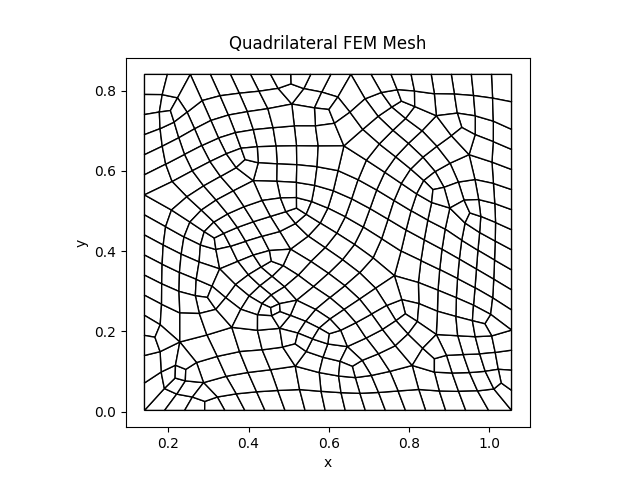

In [13]:
nodes, xnodes, ynodes, bnodes, nele, nno = readquad(ext="alt", path="files")
#[nodes,bnod,xnodes, ynodes,nele,nno] = refine_quad_mesh(nodes,bnodes,xnodes, ynodes);
#[nodes,bnod,xnodes, ynodes,nele,nno] = refine_quad_mesh(nodes,bnodes,xnodes, ynodes);
plotmesh(xnodes, ynodes, nodes)

## FEM Solve

In [14]:
# Solve FEM problem
U, Sg, Fg, Mg = FEM(nodes, xnodes, ynodes, bnodes, nele, nno)


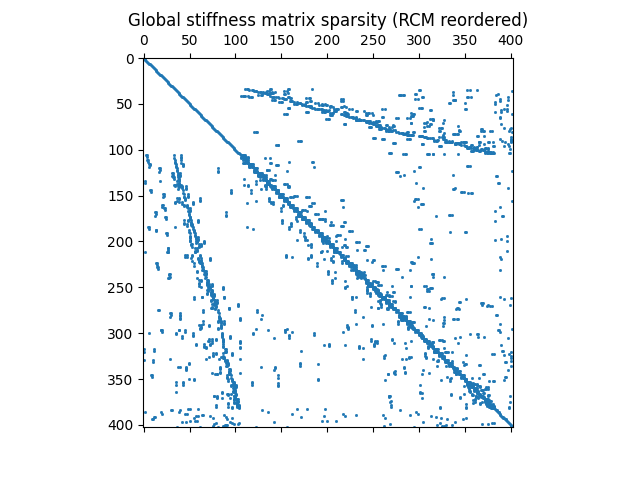

In [15]:
plt.figure()
plt.spy(Sg, markersize=1)
plt.title("Global stiffness matrix sparsity (RCM reordered)")
plt.show()


In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting

def plot_solution_3D(U, nodes, xnodes, ynodes, title="Solution 3D"):
    """
    Plot the FEM solution as a 3D surface over the quadrilateral mesh
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_trisurf(xnodes, ynodes, U, cmap='viridis')
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    ax.view_init(elev=25, azim=135)
    
    for el_nodes in nodes:
        xx = xnodes[el_nodes]
        yy = ynodes[el_nodes]
        zz = U[el_nodes]

        # Close the patch for plotting
        xx = np.append(xx, xx[0])
        yy = np.append(yy, yy[0])
        zz = np.append(zz, zz[0])

        ax.plot_trisurf(xx, yy, zz, color='lightblue', edgecolor='k', linewidth=0.5, alpha=0.8)
        
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('U')
    ax.set_title(title)



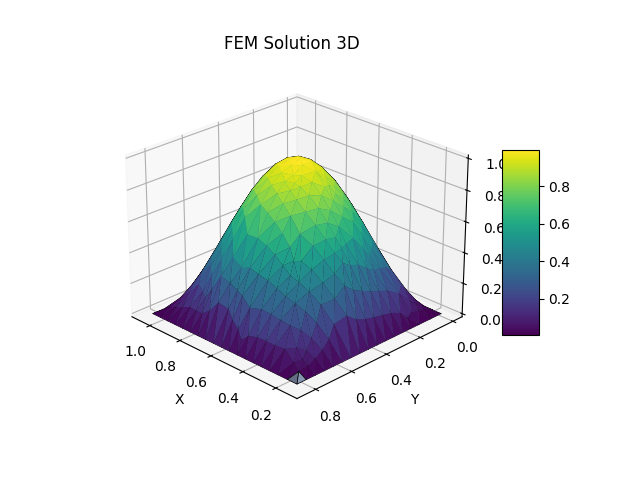

In [ ]:
plot_solution_3D(U, nodes, xnodes, ynodes, title="FEM Solution 3D")


## Error Norm

The energy norm of the error vector must go to zero as you progressively refine the mesh: 

$$
\| u_h - u \|_{L^2}
=
\sqrt{
(U - U_{\text{exact}})^T
\, M \,
(U - U_{\text{exact}})
}
$$


In [18]:
print(xnodes.min(), xnodes.max())
print(ynodes.min(), ynodes.max())


0.140893 1.05498
0.003436 0.840206


In [19]:
Ue = u_exact(xnodes, ynodes)
error_vec = U - Ue

L2_error = np.sqrt(error_vec.T @ Mg @ error_vec)
print("L2 Error norm:", L2_error)

L2 Error norm: 0.0016073854620587966


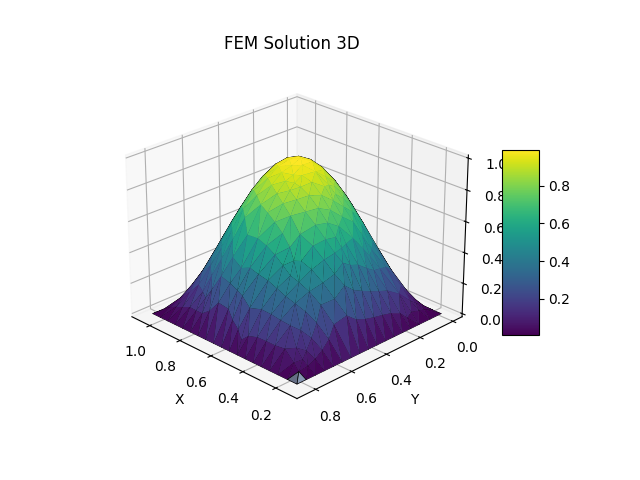

In [ ]:
plot_solution_3D(Ue, nodes, xnodes, ynodes, title="Exact Solution 3D")

Refinement 1: nno=403, nele=368, L2 error = 1.607385e-03
Refinement 2: nno=1541, nele=1472, L2 error = 3.988380e-04
Refinement 3: nno=6025, nele=5888, L2 error = 9.916283e-05
Refinement 4: nno=23825, nele=23552, L2 error = 2.472527e-05
Refinement 5: nno=94753, nele=94208, L2 error = 6.174701e-06


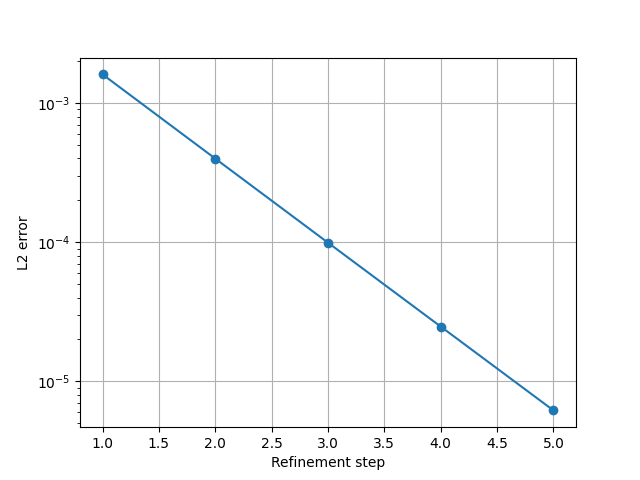

In [22]:
# Step 0: Read initial mesh
nodes, xnodes, ynodes, bnodes, nele, nno = readquad(ext="alt", path="files")

refinements = 5  # number of refinement steps
L2_errors = []

for ref in range(refinements):
    # Solve FEM on current mesh
    U, Sg, Fg, Mg = FEM(nodes, xnodes, ynodes, bnodes, nele, nno, isQuad=True)
    
    # Compute exact solution at nodes
    Ue = u_exact(xnodes, ynodes)  # user-defined exact solution
    
    # Compute L2 error
    e = U - Ue
    L2 = np.sqrt(e @ (Mg @ e))
    L2_errors.append(L2)
    
    print(f"Refinement {ref+1}: nno={nno}, nele={nele}, L2 error = {L2:e}")
    
    # Refine mesh for next iteration
    if ref < refinements - 1:
        nodes, bnodes, xnodes, ynodes, nele, nno = refine_quad_mesh(nodes, bnodes, xnodes, ynodes)

# Optional: plot convergence
import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(1, refinements+1), L2_errors, '-o')
plt.yscale('log')
plt.xlabel('Refinement step')
plt.ylabel('L2 error')
plt.grid(True)
plt.show()
